In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
import os

In [2]:
# Load the class labels
labels_path = '../data/names/obj.names'
LABELS = open(labels_path).read().strip().split("\n")

In [3]:
#load the weights and cfg
weightsPath = '../data/weights/' + 'crop_weed_detection.weights'
configPath = '../data/cfg/crop_weed.cfg'

In [4]:
# select color from bounding boces
np.random.seed(42)
#COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),dtype="uint8")
COLORS = np.array([[255, 0, 0]] * len(LABELS), dtype="uint8")

In [5]:
print("loading YOLO")
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)

# Get the names of all layers in the network
layer_names = net.getLayerNames()

loading YOLO


## There are images in /data/images to test the model. Replace the path in the imread() method to test other pictures.

In [6]:
#load our input image and grab its spatial dimensions
image = cv2.imread('../data/images/weed_4.jpeg')
(H, W) = image.shape[:2]

cv2.imshow('Image', image)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [7]:
#parameters
confi = 0.5
thresh = 0.5

In [8]:
#determine only the *output* layer names that we need from YOLO
layer_names = net.getLayerNames()
s = net.getUnconnectedOutLayers()

layer_names = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]


In [9]:
# Prepare image data for analysis and conduct a forward pass
# through the YOLO object detector to obtain  bounding_boxes and
# corresponding probability scores
blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (512, 512),swapRB=True, crop=False)
net.setInput(blob)
startTime = time.time()
layerOutputs = net.forward(layer_names)
endTime = time.time()

## Calculates the Bounding Boxes and Generates the Image Output

In [10]:

#show amount of time took to run the forward function
print("[INFO] YOLO took {:.6f} seconds".format(endTime - startTime))

bounding_boxes = []
confidences = []
classIDs = []

#loop over each of output layer
for output in layerOutputs:
    #loop over each detection
    for detection in output:
        #extract the class ID and confidence (i.e., probability) of
        #the current object detection
        scores = detection[5:]
        classID = np.argmax(scores)
        confidence = scores[classID]

        #filter out weak predictions
        if confidence > confi:
            #Rescale the bounding box coordinates to match the image size,
            #considering that YOLO provides the center (x, y)-coordinates of the bounding box
            #followed by the dimensions (width and height) of the bounding_boxes
            box = detection[0:4] * [W, H, W, H]
            (centerX, centerY, width, height) = box.astype("int")

            #Use the center (x, y)-coordinates to compute the upper-left corner
            #coordinates of the bounding box
            x = int(centerX - (width / 2))
            y = int(centerY - (height / 2))

            #update list of bounding box coordinates, confidences,
            #and class IDs
            bounding_boxes.append([x, y, int(width), int(height)])
            confidences.append(float(confidence))
            classIDs.append(classID)

[INFO] YOLO took 4.937606 seconds


In [11]:
#apply non-maxima suppression to suppress weak, overlapping bounding
#bounding_boxes
idxs = cv2.dnn.NMSBoxes(bounding_boxes, confidences, confi, thresh)

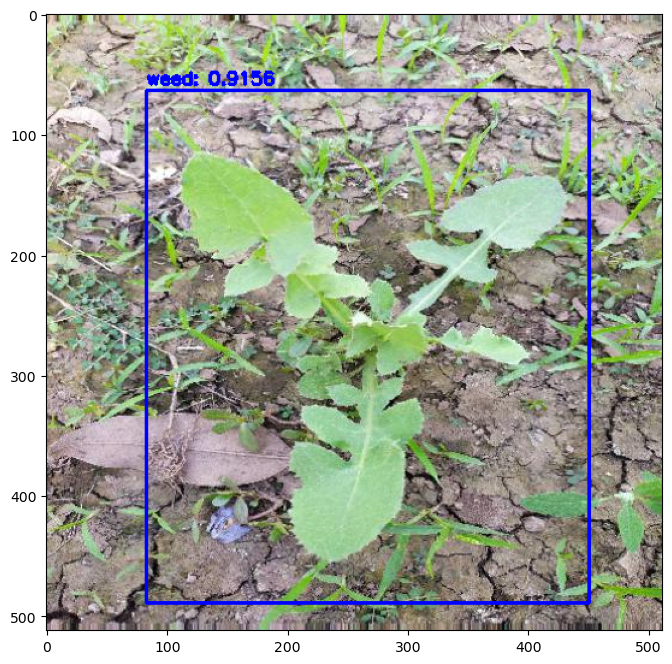

In [12]:
#check for at least one detection exists
if len(idxs) > 0:
    #loop over the indexes
    for i in idxs.flatten():
        #extract the bounding box coordinates
        (x, y) = (bounding_boxes[i][0], bounding_boxes[i][1])
        (w, h) = (bounding_boxes[i][2], bounding_boxes[i][3])
        #draw a bounding box rectangle and label on the image
        color = tuple(map(int, COLORS[classIDs[i]]))
        cv2.rectangle(image, (x, y), (x + w, y + h), color, 2)
        text = "{}: {:.4f}".format(LABELS[classIDs[i]], confidences[i])
        cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX,0.5, color, 2)
det = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12,8))
plt.imshow(det)

In [13]:
#save image
path = 'savedImage.jpeg'
det = cv2.cvtColor(det,cv2.COLOR_RGB2BGR)
cv2.imwrite(path,det)

True

In [14]:
print("Class ID : ",classIDs[-1])
if(classIDs[-1] == 1):
    print("weed detected")
else:
    print("crop detected")

Class ID :  1
weed detected
